<a href="https://colab.research.google.com/github/marie-ganon/Projet-Python-S1/blob/main/Mod%C3%A9lisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Avant de commencer à run ce notebook, il faut charger un certain nombre de fichiers : 


```
- test_review.csv.zip
- train_review.csv.zip
- unsup_filtered_review.csv.zip
```



**Introduction** 

Dans cette partie, nous nous intéressons à modéliser/prédire le "succès" d'un film selon le critère *score_1* construit dans les parties précédentes. 

Nous disposons pour cela d'un certain nombre d'indicateurs plus ou moins complets. Nous avons opté pour un modèle linéaire principalement afin de représenter l'influence entre autres du budget, du revenu ou des sentiments des commentaires sur le score.

Il s'agit donc d'améliorer le modèle en l'enrichissant notamment par une analyse sentiment pour déterminer les sentiments des commentaires dont on dispose dans les bases *test_review*, *train_review* et *unsup_filtered_review*. 

D'autre part on a intégré suite au travail effectué dans les statistiques descriptives des modalités catégorielles correspondant aux genres pour en voir la pertinence dans la régression.

La dernière partie s'intéresse aux résultats que l'on peut avoir sur un modèle random forest par rapport à nos travaux sur le modèle linéaire. 

**Intégration continue**

In [ ]:
from IPython.display import Image
try:
    im = Image("https://travis-ci.org/sdpython/ensae_teaching_cs.png")
except TimeoutError:
    im = None
im

**Sommaire** 

1. Préparation des données
  - Chargement des données
  - Analyse de la matrice de corrélation
  - Complétude des deux bases

2. Régression linéaire de *score_1* sur *budget* et *revenue*
  - Régression sur la base complète
  - Régression sur la base tronquée
  - Comparaison des deux régressions

3. Analyse de sentiments
  - Préparation des données
  - Classificateur naïf bayésien 
  - Classificateur SVM

4. Approfondissement de la régression linéaire
  - Préparation des données
  - Régression linéaire sur la base complète
  - Régression linéaire sur la base tronquée
  - Comparaison graphique des deux régressions
  - Conclusion sur l'ajout de variables

5. Ajout du semi-supervisé dans les commentaires
  - Pseudo-labelisation
  - Amélioration de la régression linéaire
  - Visualisation en variant le pourcentage de base pseudo labelisée incorporée
  - Conclusion sur l'ajout de commentaires par méthode semi-supervisée

6.   Ajout de la variable *genres* en modalités binaires

7. Ouverture : d'autres modèles ? Un random forest 




Import des modules nécessaires

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
from wordcloud import WordCloud, STOPWORDS 
import csv
import bs4
from tqdm.notebook import trange, tqdm
import seaborn as sns
import numpy as np
import random as rd

# Préparation

## Chargement des données

In [ ]:
rd.seed(42)

Import des bases : 
- *df* contient la base TMDb
- *train_review* contient la partie entraînée sur les reviews labellisés
- *test_review* contient la partie test sur les reviews labellisés
- *unsup_filtered_review* contient les reviews non labellisés filtrés sur les films contenus dans *df*



In [ ]:
 df = pd.read_csv('https://raw.githubusercontent.com/marie-ganon/Projet-Python-S1/main/Bases_import%C3%A9es/base.csv')

Avant de modéliser quoi que ce soit, nous allons supprimer les 'NaN' de la base de données.

In [ ]:
df = df.dropna()
df = df.drop(columns='Unnamed: 0')

In [ ]:
df.head()

,Unnamed: 0,index,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,collection,score_1,production_companies_name,production_companies_id,pc_id_count,country_code,country_name
0,0,0,30000000,"Animation, Comedy, Family",862,tt0114709,Anglais,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,Released,NaN,Toy Story,7.7,5415.0,1,41695.5,Pixar Animation Studios,3,29.0,US,United States of America
1,1,1,65000000,"Adventure, Fantasy, Family",8844,tt0113497,Anglais,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249.0,104.0,Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,0,16649.7,TriStar Pictures,559,163.0,US,United States of America
2,2,2,0,"Romance, Comedy",15602,tt0113228,Anglais,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,1995-12-22,0.0,101.0,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,1,598.0,Warner Bros,6194,757.0,US,United States of America
3,3,3,16000000,"Comedy, Drama, Romance",31357,tt0114885,Anglais,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,1995-12-22,81452156.0,127.0,Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,0,207.4,Twentieth Century Fox Film Corporation,306,780.0,US,United States of America
4,4,4,0,Comedy,11862,tt0113041,Anglais,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,1995-02-10,76578911.0,106.0,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,1,986.1,Sandollar Productions,5842,5.0,US,United States of America


In [ ]:
!ls

sample_data  temp_dir  test_review.csv.zip  train_review.csv.zip


In [ ]:
# Fichier temporaire

import tempfile

temp_dir = tempfile.mkdtemp()

In [ ]:
# Pour dezipper le csv disponible dans le git 

import zipfile

# IMPORTER LES FICHIERS TEST_REVIEW.CSV.ZIP et TRAIN_REVIEW.CSV.ZIP
with zipfile.ZipFile('test_review.csv.zip', 'r') as zip1, zipfile.ZipFile('train_review.csv.zip', 'r') as zip2 :
    zip1.extractall('temp_dir')
    zip2.extractall('temp_dir')

In [ ]:
test_review = pd.read_csv(r'temp_dir/test_review .csv', sep=',', low_memory = False)
train_review = pd.read_csv(r'temp_dir/train_review.csv', sep=',', low_memory = False)

## Analyse de la matrice de corrélation de *df*

Rappelons la matrice de corrélation de la base :

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,index,budget,id,popularity,revenue,runtime,vote_average,vote_count,collection,score_1,production_companies_id,pc_id_count
index,1.000000,-0.111052,0.675912,-0.113959,-0.083023,-0.171586,-0.239960,-0.071127,-0.102720,-0.072469,0.331970,-0.229618
budget,-0.111052,1.000000,-0.086690,0.412162,0.766446,0.225766,0.103634,0.665415,0.212146,0.622080,-0.160624,0.117158
id,0.675912,-0.086690,1.000000,-0.014127,-0.060123,-0.086692,-0.141201,-0.033574,-0.122764,-0.034831,0.367358,-0.186671
popularity,-0.113959,0.412162,-0.014127,1.000000,0.495219,0.161276,0.186538,0.544388,0.184730,0.534342,-0.143197,0.050937
revenue,-0.083023,0.766446,-0.060123,0.495219,1.000000,0.183763,0.137679,0.806602,0.284759,0.780984,-0.125020,0.108120
runtime,-0.171586,0.225766,-0.086692,0.161276,0.183763,1.000000,0.231019,0.199476,-0.016943,0.200588,-0.105164,0.068359
vote_average,-0.239960,0.103634,-0.141201,0.186538,0.137679,0.231019,1.000000,0.203592,0.019937,0.212963,-0.116379,0.048969
vote_count,-0.071127,0.665415,-0.033574,0.544388,0.806602,0.199476,0.203592,1.000000,0.246816,0.994176,-0.134497,0.080398
collection,-0.102720,0.212146,-0.122764,0.184730,0.284759,-0.016943,0.019937,0.246816,1.000000,0.228573,-0.100320,0.036184
score_1,-0.072469,0.622080,-0.034831,0.534342,0.780984,0.200588,0.212963,0.994176,0.228573,1.000000,-0.126350,0.075440


# Régression linéaire de *score_1* sur *budget* et *revenue*

Par construction de *score_1*, il n'est pas choquant d'observer une forte corrélation avec *popularity*, *vote_count* et *vote_average*.

On constate que bien qu'il y ait peu de données qui puissent être exploitées pour le budget et le revenu d'un film, ces deux variables sont cependant corrélées avec *score_1*, qui permet de quantifier la qualité d'un film.

Par ailleurs, la compagnie de production et la durée du film ne semblent guère influencer sa qualité. 

Tout d'abord, récupérons les données nécessaires dans le dataset.

In [ ]:
X = pd.DataFrame(np.c_[df.budget, df.revenue], columns= ['budget', 'revenue'])
Y = df.score_1

Séparons ensuite nos deux ensembles de données en bases d'apprentissage et de test.

In [ ]:

from sklearn.model_selection import train_test_split
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(13884, 2)
(3472, 2)
(13884,)
(3472,)


## Régression linéaire 

On effectue alors la régression linéaire voulue. On importe les modules nécessaires.

La fonction qu'on code va nous permettre d'évaluer les performances du modèle sur l'échantillon d'apprentissage et sur celui de test avec les $R^2$ et l'erreur quadratique moyenne. 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
def linear_model(xtrain, ytrain, xtest, ytest):
  lmodellineaire = LinearRegression()
  lmodellineaire.fit(xtrain, ytrain)
  
  # Evaluation du training set
  y_train_predict = lmodellineaire.predict(xtrain)
  rmse_train = (np.sqrt(mean_squared_error(ytrain, y_train_predict)))
  r2_train = r2_score(ytrain, y_train_predict)
  print("Performance du modèle sur la base d'apprentissage")
  print('--------------------------------------')
  print("L'erreur quadratique moyenne est {}".format(rmse_train))
  print('Le score R² est {}'.format(r2_train))
  print('\n')


  # Evaluation du testing set
  y_test_predict = lmodellineaire.predict(xtest)
  rmse_test = (np.sqrt(mean_squared_error(ytest, y_test_predict)))
  r2_test = r2_score(ytest, y_test_predict)

  print('Performance du modèle sur la base de test')
  print('--------------------------------------')
  print("L'erreur quadratique moyenne est {}".format(rmse_test))
  print('Le score R² est {}'.format(r2_test))
  print('\n')
  return y_train_predict, y_test_predict, r2_test, r2_train, rmse_test, rmse_train

In [ ]:
model1 = linear_model(X_train, Y_train, X_test, Y_test)

print(model1[2:])

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 3467.4302151622496
Le score R² est 0.6162165165800999


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 3364.076265294737
Le score R² est 0.5879873205932651


(0.5879873205932651, 0.6162165165800999, 3364.076265294737, 3467.4302151622496)


In [ ]:
l = []
l.extend(model1[2:])
l.append(len(X))


In [ ]:
table_resultats = pd.DataFrame(['r2_test', 'r2_train', 'MSE_test','MSE_train', 'count'], columns=['name'])

table_resultats['model1'] = l
table_resultats = table_resultats.set_index('name')
table_resultats

,model1
name,
r2_test,0.587987
r2_train,0.616217
MSE_test,3364.076265
MSE_train,3467.430215
count,17356.000000


Bien que le $R^2$ soit plutôt bon, ce modèle génère une erreur quadratique moyenne assez forte sur la valeur de *score_1* (de l'ordre de 3400). Cela est certainement dû à la dispersion de *score_1* :

In [ ]:
df.score_1.describe()

count     17356.000000
mean       1709.543046
std        5527.962377
min           0.000000
25%          44.800000
50%         170.000000
75%         857.700000
max      114007.500000
Name: score_1, dtype: float64

## Régression linéaire tronquée

Etudions les perfomances de ce modèle sur un échantillon comprenant les valeurs de *score_1* allant du 1er au 3ème quartile :

In [ ]:
first_quart = np.percentile(df.score_1, 25)
third_quart = np.percentile(df.score_1, 75)

In [ ]:
# Filtration des données
df_quart = df[df.score_1 > first_quart]
df_quart = df[df.score_1 < third_quart]

# Création des variables nécessaires
X2 = pd.DataFrame(np.c_[df_quart.budget, df_quart.revenue], columns= ['budget', 'revenue'])
Y2 = df_quart.score_1
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size = 0.2, random_state=5)



On observe la régression linéaire tronquée : 

In [ ]:
model2 = linear_model(X_train2, Y_train2, X_test2, Y_test2)

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 188.1704456835393
Le score R² est 0.1454504867917935


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 181.4256396942466
Le score R² est 0.1529228653745578




In [ ]:
l = []
l.extend(model2[2:])
l.append(len(X2))

table_resultats['model2'] = l
table_resultats

,model1,model2
name,,
r2_test,0.587987,0.152923
r2_train,0.616217,0.145450
MSE_test,3364.076265,181.425640
MSE_train,3467.430215,188.170446
count,17356.000000,13017.000000


Par cette nouvelle régression, nous avons certes diminué drastiquement l'erreur quadratique moyenne, cependant le $R^2$ a été divisé par 4.

## Comparaison graphique des résultats

Comparons graphiquement les résultats de la prédiction pour ces deux régressions.

In [ ]:
def plot(test, predict):
  fig, ax = plt.subplots(figsize=(8,5))
  p1 = sns.distplot(test, label = 'Vraie valeur')
  p2 = sns.distplot(predict, label = 'Prédiction')
  ax.set(xlabel= 'Valeur de score_1', ylabel = 'Densité')
  fig.legend(labels=['Vraie valeur','Prédiction'], loc = (0.75, 0.5))

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 3467.4302151622496
Le score R² est 0.6162165165800999


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 3364.076265294737
Le score R² est 0.5879873205932651


Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 188.1704456835393
Le score R² est 0.1454504867917935


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 181.4256396942466
Le score R² est 0.1529228653745578




/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/di

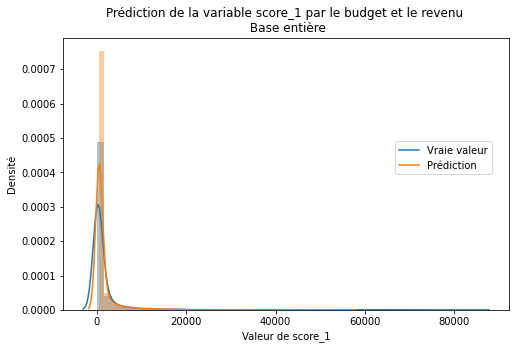

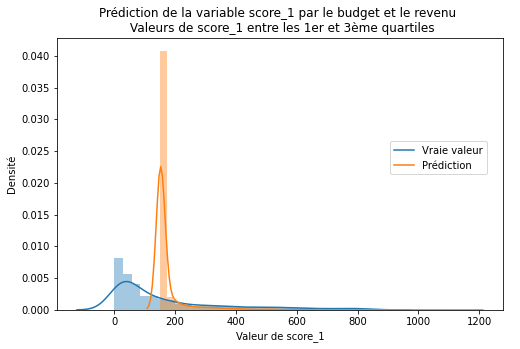

In [ ]:
plot(Y_test,linear_model(X_train, Y_train, X_test, Y_test)[1])
plt.title('Prédiction de la variable score_1 par le budget et le revenu \n Base entière')

plot(Y_test2, linear_model(X_train2, Y_train2, X_test2, Y_test2)[1])
plt.title('Prédiction de la variable score_1 par le budget et le revenu \n Valeurs de score_1 entre les 1er et 3ème quartiles')

plt.show()

Grâce à ces graphiques, on remarque qu'effectivement la première régression est nettement plus efficace que la seconde pour prédire les valeurs de *score_1*. Cependant, l'algorithme a plus de mal à prédire précisément les petites valeurs de *score_1*.

# Sentiment analysis 






L'idée derrière cette partie sur l'analyse sentiment des commentaires des spectateurs est de créer un modèle capable de prédire correctement si les sentiments dégagés par les commentaires sont positifs ou négatifs. On dispose ici de bases déjà labellisées. Mais ce travail pourrait permettre d'améliorer nos modèles en s'intéressant à une base plus importante de commentaires que l'on pourrait scraper et sur laquelle on pourrait tourner notre outil de prédiction de sentiments.


## Préparation des données

On va tenter d'enrichir notre base en rajoutant l'analyse sentiment des commentaires associés aux films. Pour cela, on utilise les base *train_review.csv.zip* et *test_review.csv.zip* importées précédemment. 


In [ ]:
train_review.head()

,Unnamed: 0,review,sentiment,url_code,rating,imdb_id,code_url
0,0,Working with one of the best Shakespeare sourc...,0,1821,4,tt0125430,1821
1,1,"Well...tremors I, the original started off in ...",0,10402,1,tt0334541,10402
2,2,Ouch! This one was a bit painful to sit throug...,0,1062,4,tt0043809,1062
3,3,"I've seen some crappy movies in my life, but t...",0,9056,1,tt0219400,9056
4,4,"""Carriers"" follows the exploits of two guys an...",0,5392,3,tt0806203,5392


In [ ]:
print(len(train_review), len(test_review))

24998 24998


On va garder les *review* des films présents dans la base *df*.

In [ ]:
l = []
l_rtest = pd.unique(test_review.imdb_id)
l_rtrain = pd.unique(train_review.imdb_id)
for elem in df.imdb_id:
  if elem in l_rtest or elem in l_rtrain : 
    l.append(elem)


On crée une fonction de filtration des reviews pour ne garder que ceux que l'on dispose.

In [ ]:
def filter_review(data):
  cond = data.apply ( lambda row : row['imdb_id'] in l , axis = 1 )
  print('On a supprimé', len(data)-len(data[cond]), 'reviews de films non attribués dans la base')
  print('\n')
  return data[cond]



In [ ]:
test_filtered = filter_review(test_review)
train_filtered = filter_review(train_review)

On a supprimé 15318 reviews de films non attribués dans la base


On a supprimé 15094 reviews de films non attribués dans la base




On va pouvoir associer les deux dataframe construits. 

In [ ]:
review_filtered = pd.concat([train_filtered, test_filtered]).reset_index()
print(len(review_filtered))

19584


In [ ]:
review_filtered = review_filtered.drop(columns='Unnamed: 0')
review_filtered.head()

,index,review,sentiment,url_code,rating,imdb_id,code_url
0,1,"Well...tremors I, the original started off in ...",0,10402,1,tt0334541,10402
1,2,Ouch! This one was a bit painful to sit throug...,0,1062,4,tt0043809,1062
2,3,"I've seen some crappy movies in my life, but t...",0,9056,1,tt0219400,9056
3,4,"""Carriers"" follows the exploits of two guys an...",0,5392,3,tt0806203,5392
4,5,I had been looking forward to seeing this film...,0,2682,3,tt0120620,2682


On tokenize puis on enlève les stopwords.

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

reviews = review_filtered.review.str.cat(sep=' ')
# on découpe selon les mots
tokens = word_tokenize(reviews)
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
words=[word.lower() for word in tokens if word.isalpha()]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
vocabulary = set(words)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(words)
print('les 10 mots les plus fréquents',sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:20])


62144
les 10 mots les plus fréquents ['br', 'i', 'movie', 'the', 'film', 'one', 'like', 'it', 'good', 'this', 'would', 'even', 'time', 'really', 'story', 'see', 'great', 'well', 'much', 'could']


Il y a encore quelques stop words qu'on va retirer. On rajoute les mots pertinents à retirer dans la liste *to_remove* jusqu'à ce que la liste des 10 mots les plus fréquents contienne des termes sans stopwords ainsi qu'uniquement des mots pertinents (par exemple *movies* ou *film* ne sont pas très pertinents puisque tous les objets sont des films ici).

In [ ]:
to_remove = ['i','br', 'the','this', 'it', 'one', 'movie', 'film']
words = [word for word in words if word not in to_remove]

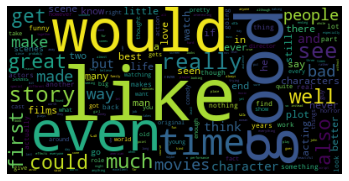

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
vocabulary = set(words)
frequency_dist = nltk.FreqDist(words)
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


Comme nous utilisons des subsets des bases d'apprentissage et d'entraînement initialement fournies, nous allons recréer ces bases pour notre modèle de sentiment analysis. 

In [ ]:
n_max = len(review_filtered)/2
n_max 

9792.0

In [ ]:
print(len(review_filtered.loc[:n_max-1, 'review'].values), len(review_filtered.loc[n_max:,'review'].values))

9792 9792


In [ ]:
x_train = review_filtered.loc[:n_max-1, 'review'].values
y_train = review_filtered.loc[:n_max-1, 'sentiment'].values
x_test = review_filtered.loc[n_max:,'review'].values
y_test = review_filtered.loc[n_max:,'sentiment'].values

## Classificateur naïf bayésien

On préprocess le texte avec *TFidfTransformer* : 

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
print(train_vectors.shape, test_vectors.shape)

(9792, 48607) (9792, 48607)


On utilise un classifier naïf bayésien pour entraîner notre modèle.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(train_vectors, y_train)

Maintenant que le modèle est entraîné, on s'intéresse au score :

In [ ]:
from  sklearn.metrics  import accuracy_score
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))


0.8278186274509803


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
tab = pd.DataFrame([[accuracy_score(y_test, predicted)], [f1_score(y_test, predicted)],[precision_score(y_test, predicted)], [recall_score(y_test, predicted)]], index=['accuracy', 'f1', 'precision', 'recall'], columns = ['score'])
tab

,score
accuracy,0.827819
f1,0.838506
precision,0.840922
recall,0.836103


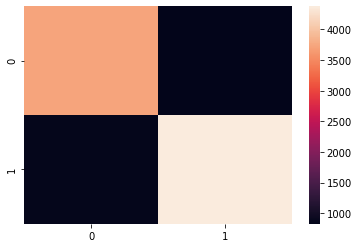

In [ ]:
c = confusion_matrix(y_test, predicted)
sns.heatmap(c)

On obtient un score de 84,71% sur la prédiction des sentiments positifs ou négatifs générés par les commentaires utilisateurs. On voit sur la matrice de confiance que les erreurs de type I (faux positifs) et de type II (faux négatifs) sont marginales. 
A priori, le classificateur est performant, mais il se trouve que SVM est une méthode d'ordinaire meilleure que le classificateur naïf bayésien. 
On va essayer d'améliorer ce score en utilisant un SVM plutôt qu'un classificateur naïf bayésien. L'avantage du classificateur naïf bayésien en dépit de sa performance est la rapidité d'exécution par rapport au SVM.

### 5-fold validation croisée

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, train_vectors, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.87799898 0.87442573 0.88508682 0.86210419 0.88100102]


## Classificateur SVM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from sklearn.svm import SVC
clf_svm = SVC(kernel='linear', C=1)
clf_svm.fit(train_vectors, y_train)
y_pred = clf.predict(test_vectors)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
tab = pd.DataFrame([[accuracy_score(y_test, y_pred)], [f1_score(y_test, y_pred)],[precision_score(y_test,y_pred)], [recall_score(y_test, y_pred)]], index=['accuracy', 'f1', 'precision', 'recall'], columns = ['score'])
tab

,score
accuracy,0.827819
f1,0.838506
precision,0.840922
recall,0.836103


En effet, le score en SVM est un peu plus élevé, avec une précision de 87,21%. Le temps d'exécution est bien plus long en revanche. 

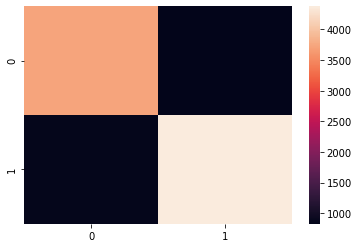

In [ ]:
c = confusion_matrix(y_test, y_pred)
sns.heatmap(c)

La matrice de confusion est à peu près inchangée.

### 5-fold validation croisée SVM

In [ ]:
scores = cross_val_score(clf_svm, train_vectors, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.90658499 0.8963757  0.90091931 0.89121553 0.90040858]


# Approfondissement de la régression


A présent, on va rajouter à la base les données de score imdb associés aux commentaires et la nature des commentaires (positifs ou négatifs) afin de voir si cela améliore la régression sur le score.

## Préparation des données

Il nous reste à agréger les reviews et les rassembler par id. 

In [ ]:
gr_review = review_filtered.groupby('imdb_id').mean()
#gr_review = gr_review.drop(columns=['Unnamed: 0', 'url_code'])


In [ ]:
print("Taille de l'échantillon final après filtration et agrégation par id des commentaires", len(pd.unique(review_filtered.imdb_id)))

Taille de l'échantillon final après filtration et agrégation par id des commentaires 1779


On agrège sur la base principale.

In [ ]:
df_2 = pd.merge(df, gr_review, left_on ='imdb_id', right_on ='imdb_id')

In [ ]:
corr = df_2[['budget', 'revenue', 'runtime', 'score_1', 'sentiment', 'rating']].corr()
corr.style.background_gradient(cmap = 'coolwarm')

,budget,revenue,runtime,score_1,sentiment,rating
budget,1.000000,0.688175,0.253552,0.534138,-0.019465,-0.028066
revenue,0.688175,1.000000,0.249538,0.780262,0.011870,0.011924
runtime,0.253552,0.249538,1.000000,0.271800,0.048067,0.043022
score_1,0.534138,0.780262,0.271800,1.000000,0.028212,0.032445
sentiment,-0.019465,0.011870,0.048067,0.028212,1.000000,0.961756
rating,-0.028066,0.011924,0.043022,0.032445,0.961756,1.000000


La matrice de corrélation ne nous indique pas une grande influence de *sentiment* et *rating* dans le *score_1* mais toutefois, comme on s'attend, la corrélation est positive. Tentons toutefois d'observer si l'ajout de ces variables améliore la prédiction.

In [ ]:
X = pd.DataFrame(np.c_[df_2.budget, df_2.revenue, df_2.rating, df_2.sentiment], columns= ['budget', 'revenue', 'rating', 'sentiment'])
Y = df_2.score_1

## Régression linéaire avec ajout de "rating" et "sentiment"

In [ ]:
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [ ]:
model3 = linear_model(X_train3, Y_train3, X_test3, Y_test3)

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 2751.7752581887908
Le score R² est 0.634456027279134


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 2778.814420793052
Le score R² est 0.451731471378768




In [ ]:
l = []
l.extend(model3[2:])
l.append(len(X))

table_resultats['model3'] = l
table_resultats

,model1,model2,model3
name,,,
r2_test,0.587987,0.152923,0.451731
r2_train,0.616217,0.145450,0.634456
MSE_test,3364.076265,181.425640,2778.814421
MSE_train,3467.430215,188.170446,2751.775258
count,17356.000000,13017.000000,1779.000000


Il semblerait que l'ajout de variables supplémentaires diminue la qualité de la prédiction. En effet, on passe d'un $R^2$ de 59% à 45%, même si on diminue l'erreur quadratique.

## Régression tronquée

Sur les 1er et 3e quartiles. 

In [ ]:
first_quart = np.percentile(df_2.score_1, 25)
third_quart = np.percentile(df_2.score_1, 75)

# Filtration des données
df_quart = df_2[df_2.score_1 > first_quart]
df_quart = df_2[df_2.score_1 < third_quart]

# Création des variables nécessaires
X2 = pd.DataFrame(np.c_[df_quart.budget, df_quart.revenue], columns= ['budget', 'revenue'])
Y2 = df_quart.score_1
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X2, Y2, test_size = 0.2, random_state=5)


In [ ]:
model4 = linear_model(X_train4, Y_train4, X_test4, Y_test4)

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 173.1820015609836
Le score R² est 0.20264541422578397


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 160.19713029033295
Le score R² est 0.21978490918629323




In [ ]:
l = []
l.extend(model4[2:])
l.append(len(X2))

table_resultats['model4'] = l
table_resultats

,model1,model2,model3,model4
name,,,,
r2_test,0.587987,0.152923,0.451731,0.219785
r2_train,0.616217,0.145450,0.634456,0.202645
MSE_test,3364.076265,181.425640,2778.814421,160.197130
MSE_train,3467.430215,188.170446,2751.775258,173.182002
count,17356.000000,13017.000000,1779.000000,1334.000000


On a encore diminué l'erreur quadratique moyenne par rapport aux premières régressions linéaires mais le $R^2$ est toujours très très faible ce qui indique une mauvaise qualité de la prédiction. Il faut noter que si on a rajouté deux features pertinents à la régression, ce rajout nous a fait perdre de l'information puisque l'échantillon a été diminué à 1779 films.

## Comparaison graphique des deux régressions

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/di

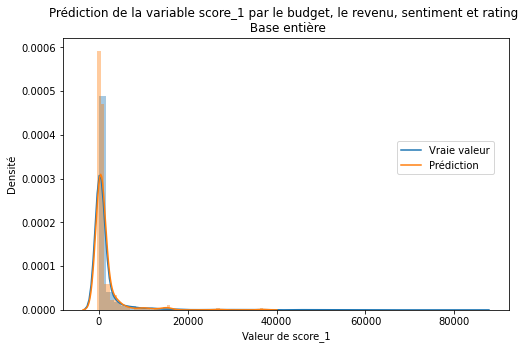

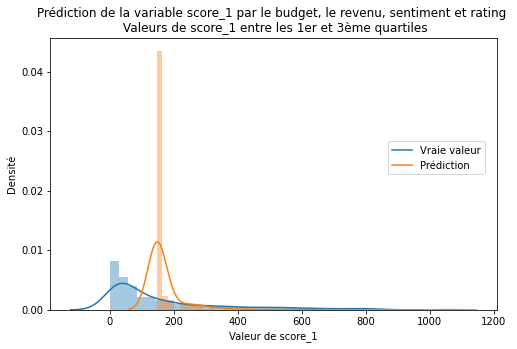

In [ ]:
plot(Y_test,model3[1])
plt.title('Prédiction de la variable score_1 par le budget, le revenu, sentiment et rating \n Base entière')

plot(Y_test2, model4[1])
plt.title('Prédiction de la variable score_1 par le budget, le revenu, sentiment et rating \n Valeurs de score_1 entre les 1er et 3ème quartiles')

plt.show()

Sur ces graphiques, on voit qu'il est nettement plus adapté de faire tourner la régression sur la base entière. En effet, la précision du modèle est grandement accrue sur les données complètes. 

## Conclusion sur l'ajout de variables explicatives

Observons les graphiques des régressions complètes en fonction des variables explicatives choisies :

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



Text(0.5, 1.0, 'Résultats des deux régressions pour la prédiction de score_1')

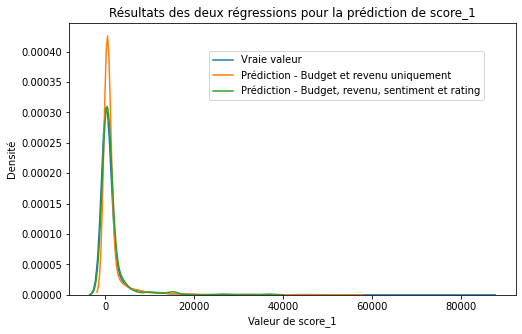

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
p1 = sns.distplot(Y_test, label = 'Vraie valeur', hist = False)
p2 = sns.distplot(model1[1], label = 'Prédiction - Budget et revenu uniquement', hist = False)
p3 = sns.distplot(model3[1], label = 'Prédiction - Budget, revenu, sentiment et rating', hist = False)
ax.set(xlabel= 'Valeur de score_1', ylabel = 'Densité')
fig.legend(labels=['Vraie valeur','Prédiction - Budget et revenu uniquement','Prédiction - Budget, revenu, sentiment et rating' ], loc = (0.4, 0.7))
plt.title('Résultats des deux régressions pour la prédiction de score_1')

Grâce à ce graphique, on constate que l'ajout de variables explicatives permet de mieux se rapprocher de la courbe des vraies valeurs, bien que le $R^2$ de cette régression eut été plus faible que celui de la régression sur le budget et le revenu uniquement.

# Ajout du semi-supervisé sur les commentaires

Le dernier modèle a été un peu amélioré mais l'échantillon ayant beaucoup été diminué, on va essayer d'inclure davantage de commentaires pour améliorer la régression linéaire sur un sous-ensemble plus important de notre base.

In [ ]:
# IMPORTER LE FICHIER UNSUP_FILTERED.CSV.ZIP
with zipfile.ZipFile(r'unsup_filtered_review.csv.zip', 'r') as zip :
      zip.extractall('temp_dir')

unsup_filtered = pd.read_csv(r'temp_dir/unsup_filtered_review.csv', sep=',', low_memory = False)



In [ ]:
unsup_filtered.head()

,Unnamed: 0,Unnamed: 0.1,review,url_code,code_url,imdb_id
0,2,2,"Very good film from director Wyler, although i...",1597,1597,tt0030287
1,3,3,"This flick will pass the time, and Kurt Russle...",27082,27082,tt0089572
2,5,5,Here is another of those films that got panned...,30084,30084,tt0163978
3,6,6,"Not sure how a filmmaker as prolific as Joel ""...",6087,6087,tt0450336
4,7,7,What? I watched this movie with my two young n...,49665,49665,tt0457419


## Pseudo-labelisation des commentaires

On va utiliser notre outil d'analyse sentiment sur cette base pour agrandir la base des commentaires. 

In [ ]:
x_train = review_filtered.loc[:n_max-1, 'review'].values
y_train = review_filtered.loc[:n_max-1, 'sentiment'].values
x_test = review_filtered.loc[n_max:,'review'].values
y_test = review_filtered.loc[n_max:,'sentiment'].values
x_test_ul = unsup_filtered['review'].values

In [ ]:
review_filtered = review_filtered.drop(columns=['index','rating'])
review_filtered.head()

,review,sentiment,url_code,imdb_id,code_url
0,"Well...tremors I, the original started off in ...",0,10402,tt0334541,10402
1,Ouch! This one was a bit painful to sit throug...,0,1062,tt0043809,1062
2,"I've seen some crappy movies in my life, but t...",0,9056,tt0219400,9056
3,"""Carriers"" follows the exploits of two guys an...",0,5392,tt0806203,5392
4,I had been looking forward to seeing this film...,0,2682,tt0120620,2682


In [ ]:
unsup_filtered = unsup_filtered.drop(columns='Unnamed: 0')

KeyError: ignored

In [ ]:
unsup_filtered.head()

,Unnamed: 0.1,review,url_code,code_url,imdb_id
0,2,"Very good film from director Wyler, although i...",1597,1597,tt0030287
1,3,"This flick will pass the time, and Kurt Russle...",27082,27082,tt0089572
2,5,Here is another of those films that got panned...,30084,30084,tt0163978
3,6,"Not sure how a filmmaker as prolific as Joel ""...",6087,6087,tt0450336
4,7,What? I watched this movie with my two young n...,49665,49665,tt0457419


On utilise notre classificateur naïf de bayes (pour la rapidité) qu'en entraîne avec les données labelisées.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
clf = MultinomialNB().fit(train_vectors, y_train)

from  sklearn.metrics  import accuracy_score
predicted = clf.predict(test_vectors)

On l'applique aux données non labelisées. On va créer une fonction qui prend en argument la proportion du sample que dont on prédit la labelisation.

In [ ]:
def label_percent(n_label): #n_label entre 0 et 1
  test_vectors_ul = vectorizer.transform(x_test_ul[:int(len(unsup_filtered)*n_label)])
  predicted_2 = clf.predict(test_vectors_ul)
  # On reconstitue un dataset avec les données labelisées et pseudo-labelisées via notre classificateur naïf bayésien
  df_unsup = unsup_filtered[:int(len(unsup_filtered)*n_label)]
  df_unsup['sentiment'] = predicted_2
  df = pd.concat([review_filtered, df_unsup])
  return df 

## Amélioration de la régression linéaire
Pour 20% de la base non labelisée : 

In [ ]:
df_pseudo_labeled = label_percent(0.2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
gr_review = df_pseudo_labeled.groupby('imdb_id').mean()
print("Taille de l'échantillon après agrégation", len(gr_review))
#gr_review = gr_review.drop(columns=['Unnamed: 0', 'url_code'])
df_2 = pd.merge(df, gr_review, left_on ='imdb_id', right_on ='imdb_id')


X = pd.DataFrame(np.c_[df_2.budget, df_2.revenue, df_2.sentiment], columns= ['budget', 'revenue', 'sentiment'])
Y = df_2.score_1

Taille de l'échantillon après agrégation 3989


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [ ]:
model_am_20 = linear_model(X_train, Y_train, X_test, Y_test)

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 2923.128003349665
Le score R² est 0.6209375264857289


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 2595.5322812124464
Le score R² est 0.6341989897920716




In [ ]:
l = []
l.extend(model_am_20[2:])
l.append(len(X))

table_resultats['model_am_20'] = l
table_resultats

,model1,model2,model3,model4,model_am_20
name,,,,,
r2_test,0.587987,0.152923,0.451731,0.219785,0.634199
r2_train,0.616217,0.145450,0.634456,0.202645,0.620938
MSE_test,3364.076265,181.425640,2778.814421,160.197130,2595.532281
MSE_train,3467.430215,188.170446,2751.775258,173.182002,2923.128003
count,17356.000000,13017.000000,1779.000000,1334.000000,3050.000000


Pour 50% de la base pseudo-labelisée :

In [ ]:
df_pseudo_labeled = label_percent(0.5)

gr_review = df_pseudo_labeled.groupby('imdb_id').mean()
print("Taille de l'échantillon après agrégation", len(gr_review))
#gr_review = gr_review.drop(columns=['Unnamed: 0', 'url_code'])
df_2 = pd.merge(df, gr_review, left_on ='imdb_id', right_on ='imdb_id')


X = pd.DataFrame(np.c_[df_2.budget, df_2.revenue, df_2.sentiment], columns= ['budget', 'revenue', 'sentiment'])
Y = df_2.score_1



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)


In [ ]:
model_am_50 = linear_model(X_train,Y_train, X_test,Y_test)

In [ ]:
l = []
l.extend(model_am_50[2:])
l.append(len(X))

table_resultats['model_am_50'] = l
table_resultats

,model1,model2,model3,model4,model_am_20,model_am_50
name,,,,,,
r2_test,0.587987,0.152923,0.451731,0.219785,0.634199,0.434614
r2_train,0.616217,0.145450,0.634456,0.202645,0.620938,0.636218
MSE_test,3364.076265,181.425640,2778.814421,160.197130,2595.532281,2640.231655
MSE_train,3467.430215,188.170446,2751.775258,173.182002,2923.128003,2912.198810
count,17356.000000,13017.000000,1779.000000,1334.000000,3050.000000,3247.000000


Les erreurs quadratiques moyennes ainsi que les $R^2$ sont moins bons sur la base test lorsque l'on utilise 50% des données pseudo-labelisées. En revanche, la prédiction est améliorée sur la base d'apprentissage... mais de manière infime. 

## Visualisation en variant le pourcentage de la base pseudo labelisée

On peut vouloir à présent déterminer l'amélioration de la prédiction selon le pourcentage de base pseudolabelisée que nous ajoutons au modèle. Pour cela nous créons une fonction à partir du code de la fonction *linear_model*. 

In [ ]:
 def for_plot_rmse_r2(pas) :
  r_train, r_test=[],[]
  mse_train, mse_test=[],[]
  for i in np.linspace(0.1,1,pas):
    df_pseudo_labeled = label_percent(i)

    gr_review = df_pseudo_labeled.groupby('imdb_id').mean()
    df_2 = pd.merge(df, gr_review, left_on ='imdb_id', right_on ='imdb_id')


    X = pd.DataFrame(np.c_[df_2.budget, df_2.revenue, df_2.sentiment], columns= ['budget', 'revenue', 'sentiment'])
    Y = df_2.score_1


    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

    model = linear_model(X_train, Y_train, X_test, Y_test) 
    #on rappelle model contient y_train_predict, y_test_predict, r2_test, r2_train, mse_test, mse_train
    
    r_test.append(model[2])
    r_train.append(model[3])
    mse_test.append(model[4])
    mse_train.append(model[5])

  return r_test, r_train, mse_test, mse_train

Comme le code de *linear_model* va générer de nombreux print, on utilise cette fonction qui va les bloquer temporairement. 

In [ ]:
# Disable
def blockPrint():
    sys.__stdout__ = sys.stdout
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__




On choisit le pas que l'on souhaite. 

In [ ]:
blockPrint()
pas = 20
rmse_r2 = for_plot_rmse_r2(pas)



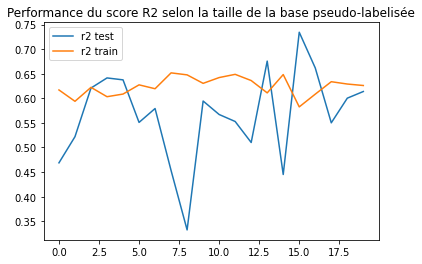

In [ ]:
plt.title("Performance du score R2 selon la taille de la base pseudo-labelisée")
plt.plot(rmse_r2[0],  label='r2 test')
plt.plot(rmse_r2[1],  label='r2 train')
plt.legend()

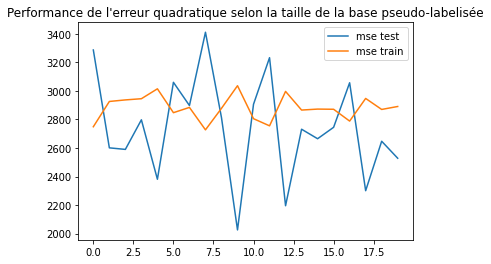

In [ ]:
plt.title("Performance de l'erreur quadratique selon la taille de la base pseudo-labelisée")
plt.plot(rmse_r2[2], label='mse test')
plt.plot(rmse_r2[3], label='mse train')
plt.legend()

In [ ]:
enablePrint()
l_min = [ rmse_r2[2].index(min(rmse_r2[2]))/pas,rmse_r2[3].index(min(rmse_r2[3]))/pas]
print("Pourcentage optimal pour minimiser MSE TEST", rmse_r2[2].index(min(rmse_r2[2]))/pas, '%')
print('\n')
print("Pourcentage optimal pour minimiser MSE TRAIN", rmse_r2[3].index(min(rmse_r2[3]))/pas, '%')


[0.45, 0.35]

In [ ]:
df_pseudo_labeled = label_percent(0.45)
gr_review = df_pseudo_labeled.groupby('imdb_id').mean()
print("Taille de l'échantillon après agrégation", len(gr_review))
#gr_review = gr_review.drop(columns=['Unnamed: 0', 'url_code'])
df_2 = pd.merge(df, gr_review, left_on ='imdb_id', right_on ='imdb_id')


X = pd.DataFrame(np.c_[df_2.budget, df_2.revenue, df_2.sentiment], columns= ['budget', 'revenue', 'sentiment'])
Y = df_2.score_1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

model_opt = linear_model(X_train,Y_train, X_test,Y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Conclusion sur l'ajout de commentaires par semi-supervisé

In [ ]:
table_resultats[['model1', 'model2' ,'model3', 'model_am_20', 'model_am_50']]

,model1,model2,model3,model_am_20,model_am_50
name,,,,,
r2_test,0.587987,0.152923,0.451731,0.634199,0.434614
r2_train,0.616217,0.145450,0.634456,0.620938,0.636218
MSE_test,3364.076265,181.425640,2778.814421,2595.532281,2640.231655
MSE_train,3467.430215,188.170446,2751.775258,2923.128003,2912.198810
count,17356.000000,13017.000000,1779.000000,3050.000000,3247.000000


Sur le tableau ci-dessus, nous avons les différentes performances des régressions linéaires sur notre base : 
- le modèle 1 est une régression linéaire du revenu et budget pour prédire le score sur la base complète. La dispersion des données donne une erreur quadratique importante. 
- le modèle 2 est la même régression sur la base tronquée sur son interquartile. On perd une partie de la base mais l'erreur est diminuée de manière impressionnante. En revanche, la qualité de la prédiction chute tout aussi drastiquement. 
- le modèle 3 est *enrichi de l'analyse sentiment sur la base labelisée* : on voit que l'erreur est un peu diminuée par rapport au modèle 1 et la qualité de la prédiction augmente avec le R2 mais on a diminuée la taille de l'échantillon d'un facteur 10 ! On ne peut pas vraiment dire que la prédiction est améliorée. 
- le modèle_am_20 est enrichi cette fois d'une partie de la base pseudo labelisée par notre algorithme de prédiction de sentiment : ce procédé permet d'augmenter un peu la taille de l'échantillon à nouveau, diminue l'erreur et augmente la pertinence des indicateurs (augmentation du R2).
- le modèle_am_50 est enrichi de 50% de la base pseudo labelisée. On s'attendrait à ce que la régression soit encore davantage performante. Dans les faits, notre algorithme de prédiction est sujet à erreurs, et plus la taille de la base sur laquelle on effectue la pseudo labelisation est grande, moins cette information est pertinente. On voit en effet que l'erreur test et le R2 test augmentent à nouveau. 

L'ensemble de ces opérations nous permet de dire qu'il faut trouver un compromis entre taille d'échantillon, échantillon semi-supervisé afin d'améliorer notre prédiction du score de film. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3

Text(0.5, 1.0, 'Résultats des deux régressions avec pseudo-labels pour la prédiction de score_1')

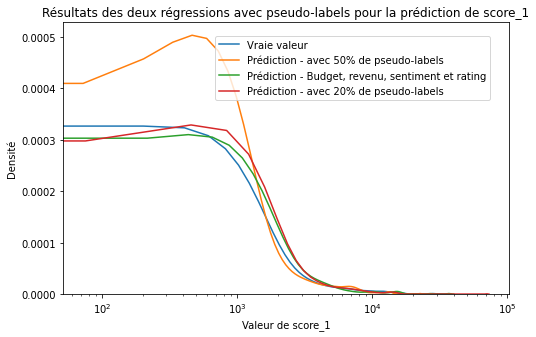

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
p1 = sns.distplot(Y_test, label = 'Vraie valeur', hist = False)
p2 = sns.distplot(model_am_50[1], label = 'Prédiction - avec 50% de pseudo-labels', hist = False)
p3 = sns.distplot(model3[1], label = 'Prédiction - Budget, revenu, sentiment et rating', hist = False)
p4 = sns.distplot(model_am_20[1], label = 'Prédiction - avec 20% de pseudo-labels', hist = False)
ax.set(xlabel= 'Valeur de score_1', ylabel = 'Densité')
ax.set_xscale('log')
fig.legend(labels=['Vraie valeur','Prédiction - avec 50% de pseudo-labels','Prédiction - Budget, revenu, sentiment et rating' ,'Prédiction - avec 20% de pseudo-labels'], loc = (0.4, 0.7))
plt.title('Résultats des deux régressions avec pseudo-labels pour la prédiction de score_1')

Il apparaît que les "meilleures" prédictions du score sont obtenues avec le budget, le revenu, les sentiment et le rating sans pseudo labelisé ou la prédiction avec 20% de pseudo-labels. 

# Ajout de variable *genres* en modalité catégorielles

In [ ]:
df['main_genre']=df.genres.str.split(',').str.get(0)

In [ ]:
l_genres = pd.unique(df.main_genre)
l_genres

array(['Adventure', 'Romance', 'Comedy', 'Action', 'Family', 'History',
       'Drama', 'Crime', 'Fantasy', 'Science', 'Music', 'Horror',
       'Documentary', 'Mystery', 'Thriller', 'Animation', 'War',
       'Western', 'Foreign', 'TV'], dtype=object)

Nous allons créer les variables de modalité pour chaque genre. On va utiliser OneHotEncoder pour créer notre dataframe de modalité.

In [ ]:
df_dummy = pd.get_dummies(df.main_genre)

On agrège à notre base. 

In [ ]:
df_dummy.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science,TV,Thriller,War,Western
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = pd.concat([df[['budget', 'revenue']], df_encode[l_genres]], axis=1)
Y = df.score_1

X = X.dropna(axis=0)
Y = Y.dropna(axis=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

On applique la régression linéaire.

In [ ]:
model_genre = linear_model(X_train, Y_train, X_test, Y_test)

In [ ]:
l = []
l.extend(model_genre[2:])
l.append(len(X))

table_resultats['model_genre'] = l
table_resultats

,model1,model2,model3,model4,model_am_20,model_am_50,model_opt,model_genre
name,,,,,,,,
r2_test,0.587987,0.152923,0.451731,0.219785,0.634199,0.434614,0.443857,0.589279
r2_train,0.616217,0.145450,0.634456,0.202645,0.620938,0.636218,0.654358,0.618358
MSE_test,3364.076265,181.425640,2778.814421,160.197130,2595.532281,2640.231655,3444.024579,3358.798468
MSE_train,3467.430215,188.170446,2751.775258,173.182002,2923.128003,2912.198810,2713.122531,3457.743850
count,17356.000000,13017.000000,1779.000000,1334.000000,3050.000000,3247.000000,3216.000000,17356.000000


L'ajout des genres dans les features de la régression laisse celle-ci presqu'inchangée du point de vue de l'erreur quadratique moyenne ainsi que du R2. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3

Text(0.5, 1.0, 'Résultats de la régression avec genres pour la prédiction de score_1')

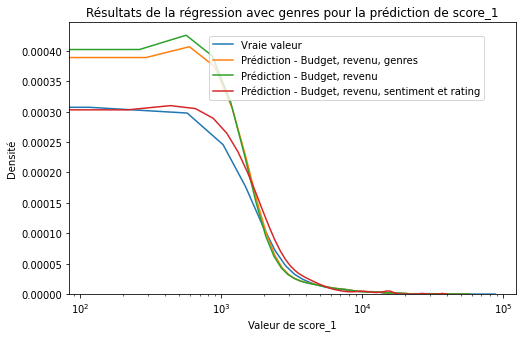

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
p1 = sns.distplot(Y_test, label = 'Vraie valeur', hist = False)
p2 = sns.distplot(model_genre[1], label = 'Prédiction - Budget, revenu, genres', hist = False)
p3 = sns.distplot(model1[1], label = 'Prédiction - Budget, revenu', hist = False)
p3 = sns.distplot(model3[1], label = 'Prédiction - Budget, revenu, sentiments, rating', hist = False)
ax.set(xlabel= 'Valeur de score_1', ylabel = 'Densité')
ax.set_xscale('log')
fig.legend(labels=['Vraie valeur','Prédiction - Budget, revenu, genres','Prédiction - Budget, revenu','Prédiction - Budget, revenu, sentiment et rating' ,'Prédiction - avec 20% de pseudo-labels'], loc = (0.4, 0.7))
plt.title('Résultats de la régression avec genres pour la prédiction de score_1')

On voit que l'ajout du genre n'est pas particulièrement pertinent sur la valeur du score par rapport à l'ajout des sentiments et ratings. En effet, comme nous l'avions vu dans les statistiques descriptives avec la LDA, le genre du film n'est pas une information très utile pour prédire le succès d'un film, de même que les films à succès  semblent être en particulier ceux dont le synopsis sort de l'ordinaire. 

L'ensemble de ces observations porte à interpréter la "recette" du succès d'un film comme l'absence de recette  !

# Ouverture : d'autres modèles ? Un random forest

Un autre type de régresseur un peu plus élaboré est le Random Forest Regressor. On va prendre un hyperparamètre *n_estimators* de 10 pour commencer (10 arbres). 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def rf_model(n_estimators, xtrain, xtest, ytrain, ytest):

  regressor = RandomForestRegressor(n_estimators, random_state = 0)
  regressor.fit(xtrain, ytrain)


  y_train_predict = regressor.predict(xtrain)

  rmse_train = (np.sqrt(mean_squared_error(ytrain, y_train_predict)))
  r2_train = r2_score(ytrain, y_train_predict)
  print("Performance du modèle sur la base d'apprentissage")
  print('--------------------------------------')
  print("L'erreur quadratique moyenne est {}".format(rmse_train))
  print('Le score R² est {}'.format(r2_train))
  print('\n')


  # Evaluation du testing set
  y_test_predict = regressor.predict(xtest)
  rmse_test = (np.sqrt(mean_squared_error(ytest, y_test_predict)))
  r2_test = r2_score(ytest, y_test_predict)

  print('Performance du modèle sur la base de test')
  print('--------------------------------------')
  print("L'erreur quadratique moyenne est {}".format(rmse_test))
  print('Le score R² est {}'.format(r2_test))
  print('\n')
  return y_train_predict, y_test_predict, r2_test, r2_train, rmse_test, rmse_train

In [ ]:
X = pd.DataFrame(np.c_[df.budget, df.revenue], columns= ['budget', 'revenue'])
Y = df.score_1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
len(X_train), len(X_test), len(Y_train), len(Y_test)

(13884, 3472, 13884, 3472)

In [ ]:
model_rf = rf_model(10, X_train, X_test, Y_train, Y_test)

Visualisons un peu nos prédictions.

Text(0.5, 1.0, 'Score prédit en fonction du score réel ')

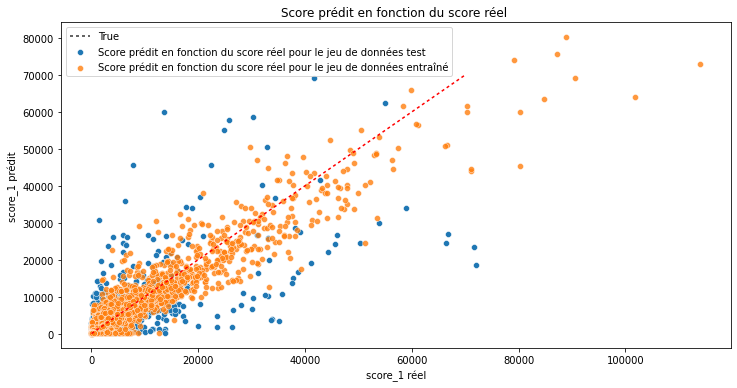

In [ ]:


fig, ax = plt.subplots(figsize=(12,6))
res_test = pd.DataFrame({'score_1 réel': Y_test, 'score_1 prédit': model_rf[1]})
sns.scatterplot(data=res_test, x="score_1 réel",y="score_1 prédit", label="Score prédit en fonction du score réel pour le jeu de données test")
identite = [i for i in range(0, 70000)]
sns.lineplot(x=identite,y=identite,style=True, dashes=[(2,2)],color="red")



res_train = pd.DataFrame({'score_1 réel': Y_train, 'score_1 prédit': model_rf[0]})
sns.scatterplot(data=res_train, x="score_1 réel",y="score_1 prédit", alpha=0.8, label="Score prédit en fonction du score réel pour le jeu de données entraîné")

plt.title("Score prédit en fonction du score réel ")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/di

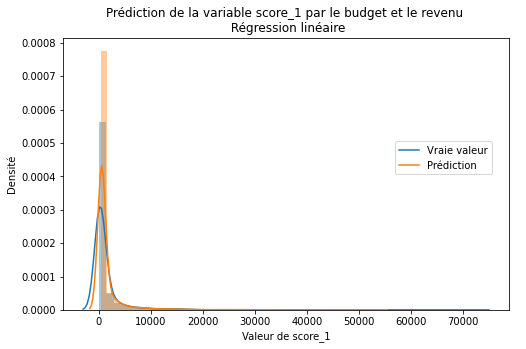

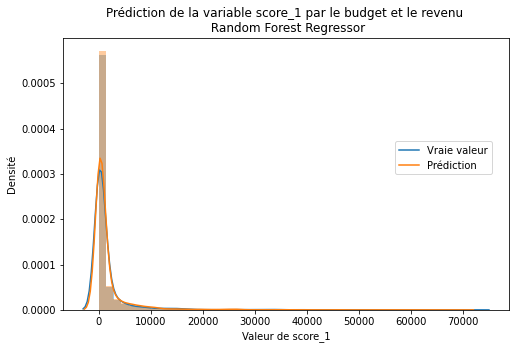

In [ ]:
plot(Y_test,linear_model(X_train, Y_train, X_test, Y_test)[1])
plt.title('Prédiction de la variable score_1 par le budget et le revenu \n Régression linéaire')

plot(Y_test, model_rf[1])
plt.title('Prédiction de la variable score_1 par le budget et le revenu \n Random Forest Regressor')

plt.show()

Le Random Forest est plus efficace pour la prédiction que le modèle linéaire. On pourrait tenter d'ajuster ce modèle de la même manière que la régression linéaire, toutefois, on a vu que l'ajout des commentaires et des sentiments tronquait de manière importante la quantité de données exploitables ce qui ne serait pas idéal pour un Random Forest. 

# Conclusion de la modélisation


On a utilisé différentes méthodes de Machine Learning afin de modéliser la "recette" du succès d'un film. 

Dans les parties précédentes, nous avions construits des indicateurs de succès (confrontant  la popularité à un score mélangeant succès critique et popularité). En regardant les différentes variables, nous avions noté un certain nombre de caractéristiques des films : la prédominance de certains genres dans l'ensemble des films, par des méthodes de NLP, nous avons cherché à caractériser les topics pour des films à succès. La conclusion précédente était qu'il n'y avait pas de topic particulier pour des films à succès. 

D'autre part nous avions regardé des variables qui n'ont pas été utilisées dans la modélisation mais qui auraient pu être pertinentes pour expliquer le succès ou non d'un film : comme la compagnie produisant le film (variable qui peut être corrélée au budget du film qui est mal renseigné !) ou encore la provenance géographique du film. 

Dans cette partie de modélisation où nous cherchons à prédire le score d'un film (donc son succès), nous avons choisi un modèle simple car en effet de nombreuses informations sont manquantes dans le budget et le revenu. Nous avons aussi cherché à améliorer la **régression linéaire** par différentes méthodes en enrichissant notre base par du *sentiment analysis* sur un batch de commentaires imdb par des méthodes supervisées et semi-supervisées. La comparaison des résultats fait ressortir l'importance de choisir un compromis entre réduction/augmentation de notre échantillon et ajout de features plus ou moins intéressants. Et comme l'on pouvait s'y attendre de nos observations précédentes, le genre est un indicateur médiocre pour prédire le succès d'un film. 

Nous avons terminé par entraîner un modèle de Random Forest sur la base la plus complète possible (avec comme features le budget et le revenu) pour prédire le score. La performance du Random Forest améliore celle de la régression linéaire, trop "simple" sans doute pour prédire le succès d'un film. Mais à nouveau, il paraît difficile d'ajuster le modèle en rajoutant des variables d'intérêt sans diminuer la qualité de la prédiction par la diminution drastique de la quantité de données. 

En conclusion, prédire la "recette à succès" d'un film est une tâche difficile, et nos résultats sont davantages la preuve qu'il n'y a pas réellement de recette que le contraire. Toutefois, l'influence du budget et l'indication des revenus du films sont des informations pertinentes ainsi que les sentiments engendrés récupérés via les commentaires. 